<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_4_Regression_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Clone the repository
# !git clone https://github.com/young-hwanlee/practical-statistics-for-data-scientists.git

# # Open the file from the list of contents (File)
# # Then, copy and paste it

Cloning into 'practical-statistics-for-data-scientists'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 363 (delta 75), reused 93 (delta 27), pack-reused 207
Receiving objects: 100% (363/363), 83.68 MiB | 33.80 MiB/s, done.
Resolving deltas: 100% (161/161), done.


## Practical Statistics for Data Scientists (Python)
## Chapter 4. Regression and Prediction
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [1]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 10.4 MB/s 


In [2]:
!pip install dmba

     |████████████████████████████████| 11.8 MB 20.5 MB/s 


In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend


In [4]:
%matplotlib inline

In [ ]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [5]:
# LUNG_CSV = DATA / 'LungDisease.csv'
# HOUSE_CSV = DATA / 'house_sales.csv'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

LUNG_CSV = DATA + 'LungDisease.csv'
HOUSE_CSV = DATA + 'house_sales.csv'

## **4.1 Simple Linear Regression**
### **4.1.1 The Regression Equation**

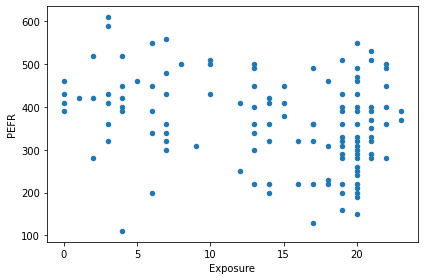

In [6]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

We can use the `LinearRegression` model from _scikit-learn_.

In [7]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


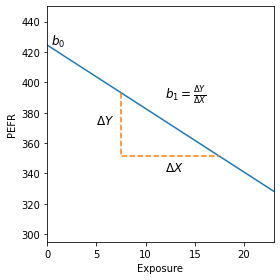

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


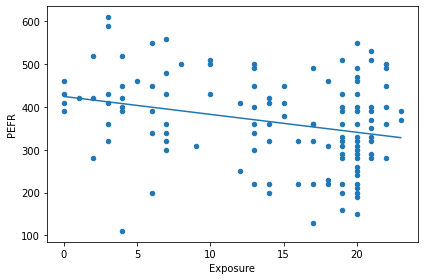

In [9]:
lung.plot.scatter(x='Exposure', y='PEFR')
plt.plot((0, 23), model.predict([[0], [23]]))

plt.tight_layout()
plt.show()

### **4.1.2 Fitted Values and Residuals**

The method `predict` of a fitted _scikit-learn_ model can be used to predict new data points.

In [10]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

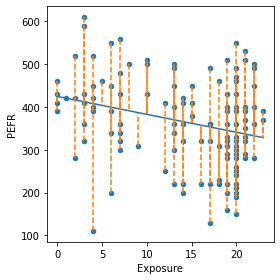

In [11]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

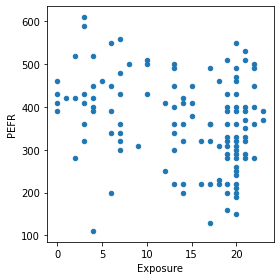

In [12]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))

plt.tight_layout()
plt.show()

## **4.2 Multiple linear regression**

In [ ]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

### **4.2.2 Assessing the Model**

_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score`.

In [ ]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [ ]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

### **4.2.4 Model Selection and Stepwise Regression**

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

We can use the `stepwise_selection` method from the _dmba_ package.

In [ ]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

### **4.2.5 Weighted regression**

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [ ]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

In [ ]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

## **4.4 Factor variables in regression**
### **4.4.1 Dummy Variables Representation**

In [ ]:
print(house.PropertyType.head())

In [ ]:
print(pd.get_dummies(house['PropertyType']).head(6))

In [ ]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

### **4.4.2 Factor Variables with many levels**

In [ ]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

In [ ]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

In [ ]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

## **4.5 Interpreting the Regression Equation**
### **4.5.1 Correlated predictors**

The results from the stepwise regression are.

In [ ]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

In [ ]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

### **4.5.3 Confounding variables**

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

### **4.5.4 Interactions and Main Effects**

In [ ]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

> Results differ from R due to different binning. Enforcing the same binning gives identical results

## **4.6 Testing the Assumptions: Regression Diagnostics**
### **4.6.1 Outliers**

The _statsmodels_ package has the most developed support for outlier analysis.

In [ ]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals.

In [ ]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

In [ ]:
print(result_98105.resid.loc[sresiduals.idxmin()])

In [ ]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

### **4.6.2 Influential values**

In [ ]:
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

The package _statsmodel_ provides a number of plots to analyze the data point influence.

In [ ]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [ ]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

### **4.6.3 Heteroskedasticity, Non-Normality and Correlated Errors**

The `regplot` in _seaborn_ allows adding a lowess smoothing line to the scatterplot.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

### **4.6.4 Partial Residual Plots and Nonlinearity**

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## **4.7 Polynomial and Spline Regression**

In [ ]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

In [ ]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

### **4.7.2 Splines**

In [ ]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

### **4.7.3 Generalized Additive Models**

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

In [ ]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

## **Additional material - not in book**
## **Regularization**
### **Lasso**

In [ ]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler


In [ ]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

In [ ]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

In [ ]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [1]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

NameError: ignored

In [ ]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308